In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [37]:
new_df = pd.read_csv('sentiment_scored.csv')

In [38]:
new_df = new_df.sort_values(by='timestamp')

In [39]:
new_df['timestamp'] = pd.to_datetime(new_df['timestamp'], errors='coerce')

### Performing Moving Average

In [40]:
new_df['moving_average_neg'] = new_df['rob_neg'].rolling(window=30, min_periods=1).mean()
new_df['moving_average_neu'] = new_df['rob_neu'].rolling(window=30, min_periods=1).mean()
new_df['moving_average_pos'] = new_df['rob_pos'].rolling(window=30, min_periods=1).mean()

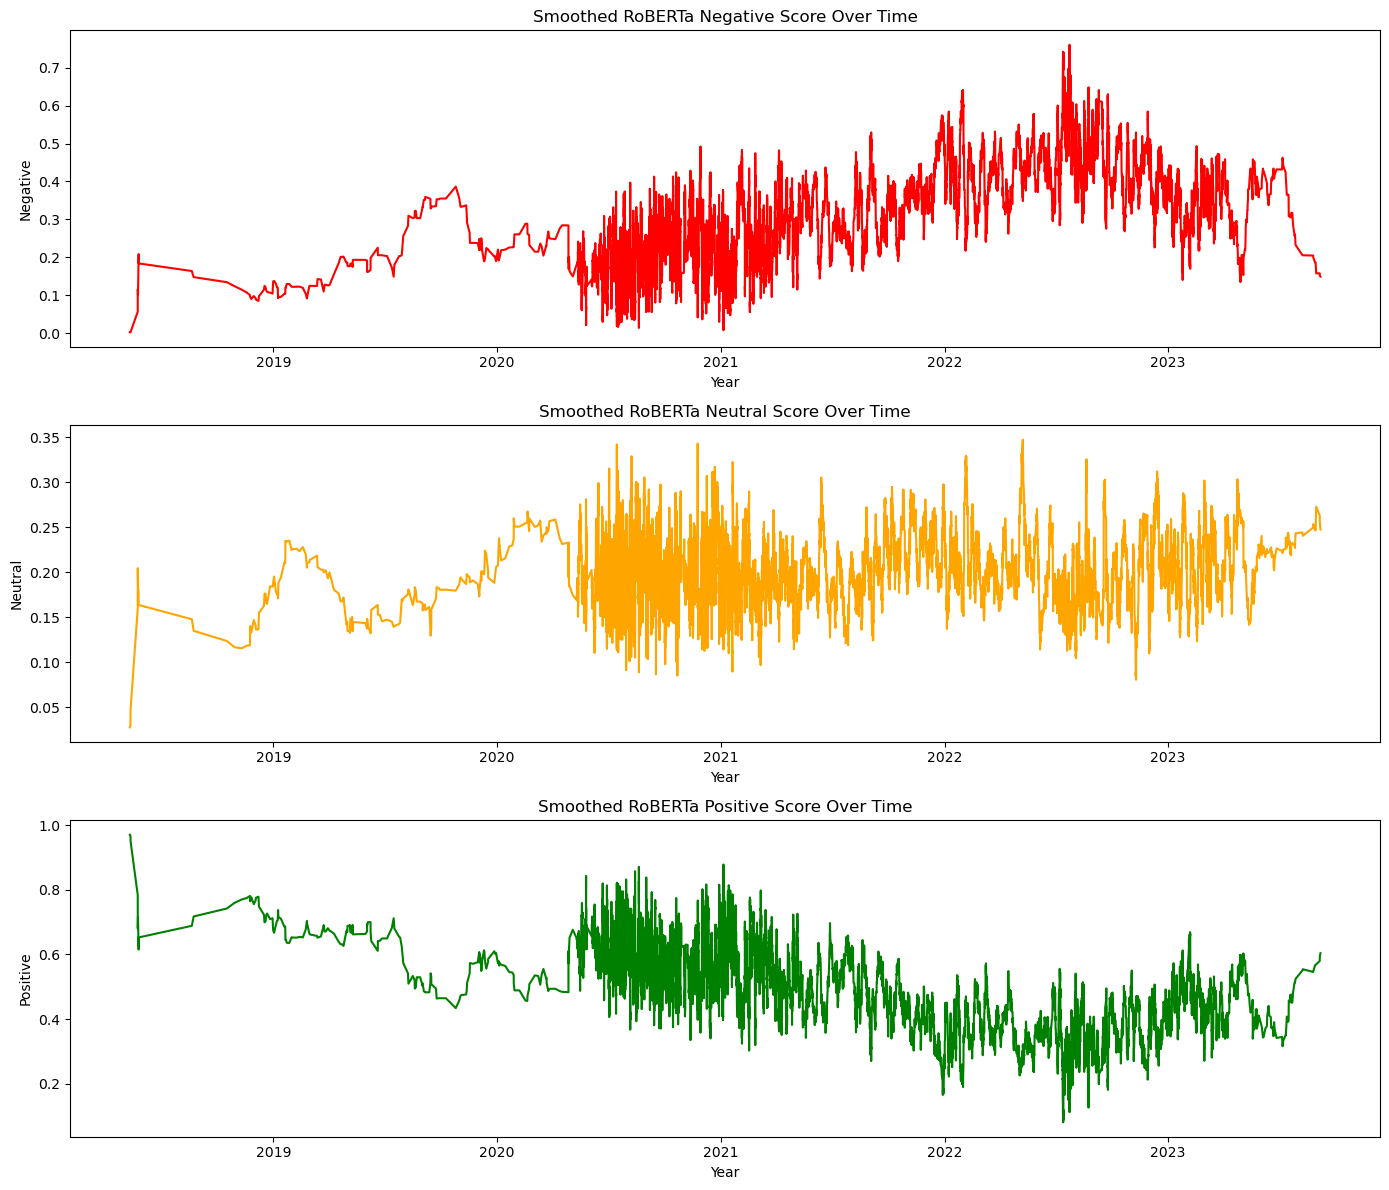

In [41]:
fig, arr = plt.subplots(3, 1, figsize=(14, 12))

arr[0].plot(new_df['timestamp'], new_df['moving_average_neg'], color='red')
arr[0].set_title("Smoothed RoBERTa Negative Score Over Time")
arr[0].set_ylabel("Negative")
arr[0].set_xlabel("Year")

arr[1].plot(new_df['timestamp'], new_df['moving_average_neu'], color='orange')
arr[1].set_title("Smoothed RoBERTa Neutral Score Over Time")
arr[1].set_ylabel("Neutral")
arr[1].set_xlabel("Year")

arr[2].plot(new_df['timestamp'], new_df['moving_average_pos'], color='green')
arr[2].set_title("Smoothed RoBERTa Positive Score Over Time")
arr[2].set_ylabel("Positive")
arr[2].set_xlabel("Year")

plt.tight_layout()
plt.show()


In [42]:
class Forecast_Sentiments:
    
    def __init__(self):
        self.WINDOW_SIZE = 180
        self.X = None
        self.y = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.cp = None
        self.model1 = None
        self.history = None
        self.best_model = None
        self.pos_result = None
        self.earlystopping = EarlyStopping( 
                            monitor="val_loss",
                            patience=1,
                            verbose=1,
                            mode="min",)
    
    def df_to_X_y(self,df,window_Size = 180):
        df_as_numpy = df.to_numpy()
        X = []
        y = []
        for i in tqdm(range(len(df_as_numpy) - window_Size)):
            row = [[a] for a in df_as_numpy[i:i + window_Size]]
            X.append(row)
            label = df_as_numpy[i + window_Size]
            y.append(label)

        self.X = np.array(X)
        self.y = np.array(y)
    
    def split_data_points(self,size = 12000):
        self.X_train , self.y_train = np.array(self.X[:size]), np.array(self.y[:size])
        self.X_test , self.y_test = np.array(self.X[size:]) , np.array(self.y[size:])
        
    
    def train_stacked_lstm_model(self, learning_rate=0.001):
        self.model1 = Sequential()
        self.model1.add(InputLayer((self.WINDOW_SIZE, 1)))

        self.model1.add(LSTM(64, return_sequences=True))
        self.model1.add(Dropout(0.2))

        self.model1.add(LSTM(64, return_sequences=True))
        self.model1.add(Dropout(0.2))

        self.model1.add(LSTM(64))
        self.model1.add(Dropout(0.2))

        self.model1.add(Dense(8, activation='relu'))
        self.model1.add(Dense(1, activation='linear'))

        self.model1.summary()

        self.cp = ModelCheckpoint('model1_best.keras', save_best_only=True)

        self.model1.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=learning_rate),metrics=[RootMeanSquaredError()])
        
    def fit_model(self,epochs = 50):
        self.history = self.model1.fit(
        self.X_train,
        self.y_train,
        validation_split=0.2,
        epochs=epochs,
        callbacks=[self.cp, self.earlystopping]
        )

        plt.figure(figsize=(10, 5))
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Training vs Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
            
        
        
    
    def forecast_model(self):
        self.best_model = load_model('model1_best.keras')
        temp = self.best_model.predict(self.X_test)
        return pd.DataFrame(data = {'Test Prediction' : temp.flatten(),'Actual' : self.y_test})
        
    
    def evaluation(self,model):
        
        mse = mean_squared_error(model['Test Prediction'],model['Actual'])
        rmse = np.sqrt(mse)
        r2 = r2_score(model['Test Prediction'],model['Actual'])
        mae = mean_absolute_error(model['Test Prediction'],model['Actual'])

        print('mse : ',mse)
        print('rmse : ',rmse)
        print('r2 : ',r2)
        print('mae : ',mae)
        
        
    def forecast_visual(self,model,text):
        plt.figure(figsize=(12, 5))

        plt.plot(model['Test Prediction'], color='blue', label='Predicted')
        plt.plot(model['Actual'], color='red', label='Actual')

        plt.title(f'{text} Sentiment Model Prediction vs Actual Values')
        plt.xlabel('Time Step')
        plt.ylabel('Sentiment Score')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
    

In [43]:
negative_sentiment = Forecast_Sentiments()
neutral_sentiment = Forecast_Sentiments()
positive_sentiment = Forecast_Sentiments()


### Peforming Model For Negative Sentiment

In [44]:
negative_sentiment.df_to_X_y(new_df['moving_average_neg'])

100%|██████████| 16677/16677 [00:02<00:00, 7581.74it/s] 


In [45]:
negative_sentiment.split_data_points()

In [46]:
negative_sentiment.train_stacked_lstm_model(learning_rate=0.001)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 180, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 180, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 180, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 180, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,473 (326.07 KB)

 Trainable params: 83,473 (326.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - loss: 0.0048 - root_mean_squared_error: 0.0658 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0394
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325 - val_loss: 8.9964e-04 - val_root_mean_squared_error: 0.0300
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - loss: 7.3886e-04 - root_mean_squared_error: 0.0272 - val_loss: 5.6051e-04 - val_root_mean_squared_error: 0.0237
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - loss: 5.5154e-04 - root_mean_squared_error: 0.0235 - val_loss: 4.6581e-04 - val_root_mean_squared_error: 0.0216
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - loss: 4.4631e-04 - root_mean_squared_error: 0.0211 - val_loss: 3.6511e-04 - val_root_mean_squared_error: 0.0191
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - loss: 3.8168e-04 - root_mean_squared_error: 0.0195 - val_loss: 3.3814e-04 - val_root_mean_squared_error: 0.0184
Epoc

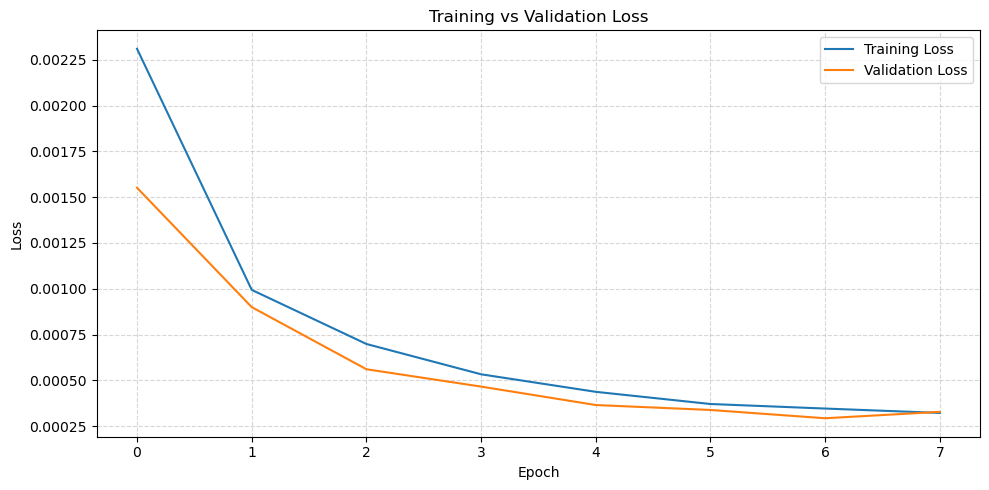

In [47]:
negative_sentiment.fit_model()

In [48]:
negative_sentiment_model = negative_sentiment.forecast_model()

147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


In [49]:
negative_sentiment.evaluation(negative_sentiment_model)

mse :  0.00042776810319842683
rmse :  0.020682555528716146
r2 :  0.9525987441845076
mae :  0.01679835277476954


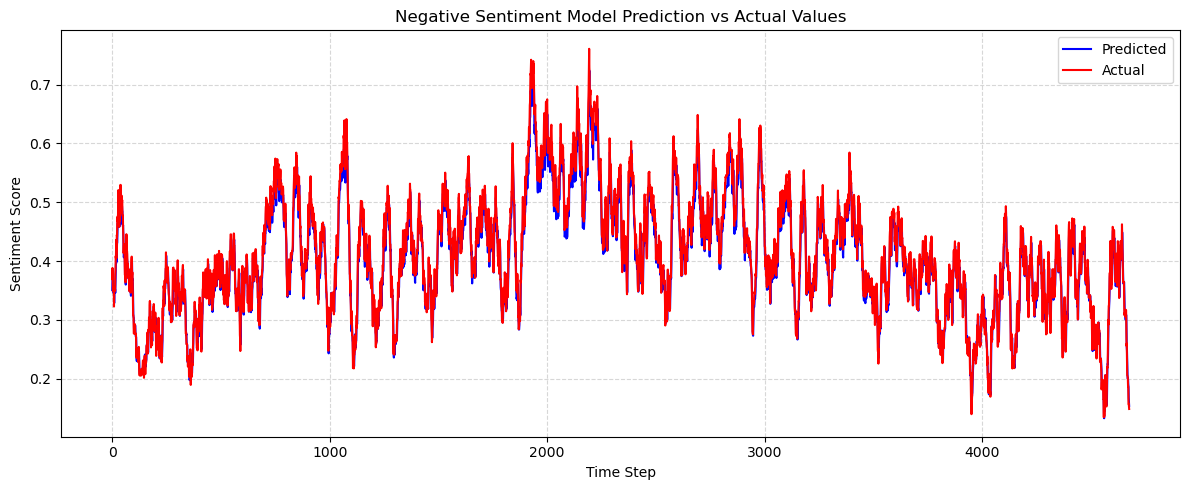

In [50]:
negative_sentiment.forecast_visual(negative_sentiment_model,text = 'Negative')

### Peforming Model For Positive Sentiment

In [51]:
positive_sentiment.df_to_X_y(new_df['moving_average_pos'])

100%|██████████| 16677/16677 [00:02<00:00, 7779.97it/s]


In [52]:
positive_sentiment.split_data_points()

In [53]:
positive_sentiment.train_stacked_lstm_model(learning_rate=0.0001)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 180, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 180, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 180, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 180, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,473 (326.07 KB)

 Trainable params: 83,473 (326.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - loss: 0.1166 - root_mean_squared_error: 0.3201 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0697
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0654
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - loss: 0.0061 - root_mean_squared_error: 0.0779 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0611
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - loss: 0.0053 - root_mean_squared_error: 0.0725 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0600
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - loss: 0.0048 - root_mean_squared_error: 0.0692 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0511
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - loss: 0.0043 - root_mean_squared_error: 0.0655 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0514
Epoch 6: early stopping


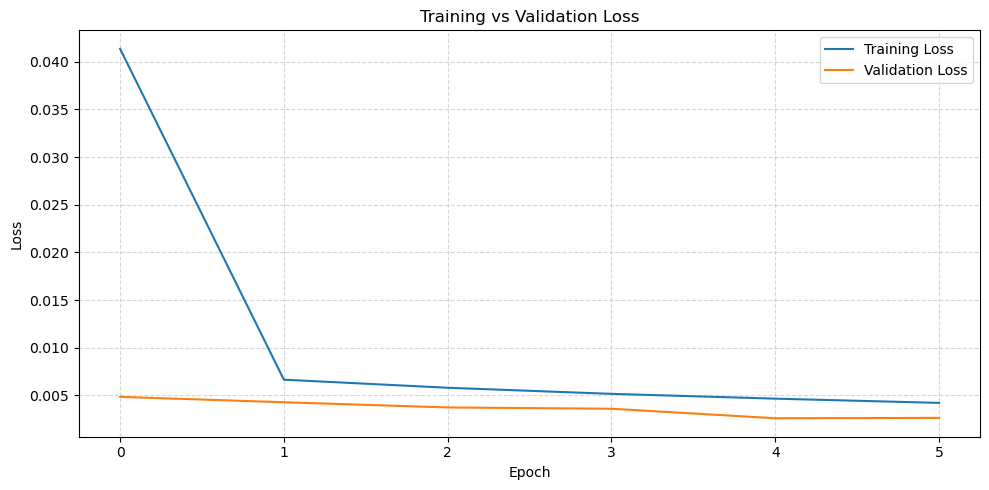

In [54]:
positive_sentiment.fit_model()

In [55]:
positive_sentiment_model = positive_sentiment.forecast_model()

147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


In [56]:
positive_sentiment.evaluation(positive_sentiment_model)

mse :  0.0047041341075559325
rmse :  0.06858669045489753
r2 :  -0.08610917847417143
mae :  0.056505104199484894


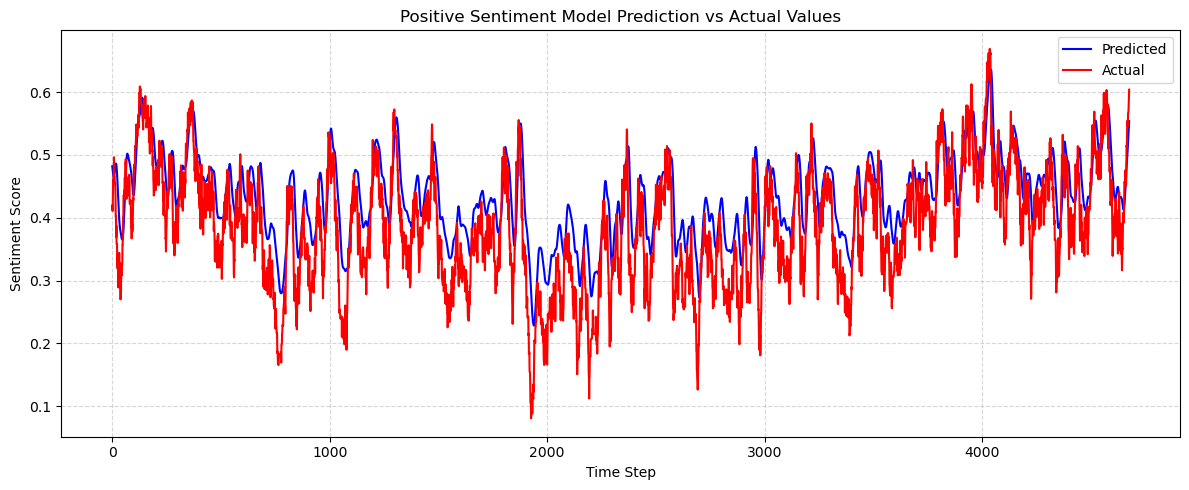

In [57]:
positive_sentiment.forecast_visual(positive_sentiment_model,text='Positive')

### Performing Model For Neutral sentiment

In [58]:
neutral_sentiment.df_to_X_y(new_df['moving_average_neu'])

100%|██████████| 16677/16677 [00:02<00:00, 7852.71it/s]


In [59]:
neutral_sentiment.split_data_points()

In [60]:
neutral_sentiment.train_stacked_lstm_model(learning_rate=0.001)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 180, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 180, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 180, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 180, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,473 (326.07 KB)

 Trainable params: 83,473 (326.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 25s 74ms/step - loss: 0.0035 - root_mean_squared_error: 0.0541 - val_loss: 3.9261e-04 - val_root_mean_squared_error: 0.0198
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - loss: 6.0028e-04 - root_mean_squared_error: 0.0245 - val_loss: 3.1401e-04 - val_root_mean_squared_error: 0.0177
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - loss: 4.4905e-04 - root_mean_squared_error: 0.0212 - val_loss: 2.6525e-04 - val_root_mean_squared_error: 0.0163
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - loss: 3.4656e-04 - root_mean_squared_error: 0.0186 - val_loss: 2.2061e-04 - val_root_mean_squared_error: 0.0149
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - loss: 2.7539e-04 - root_mean_squared_error: 0.0166 - val_loss: 1.8955e-04 - val_root_mean_squared_error: 0.0138
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - loss: 2.3669e-04 - root_mean_squared_error: 0.0154 - val_loss: 1.3624e-04 - val_root_mean_squared_error: 0.0

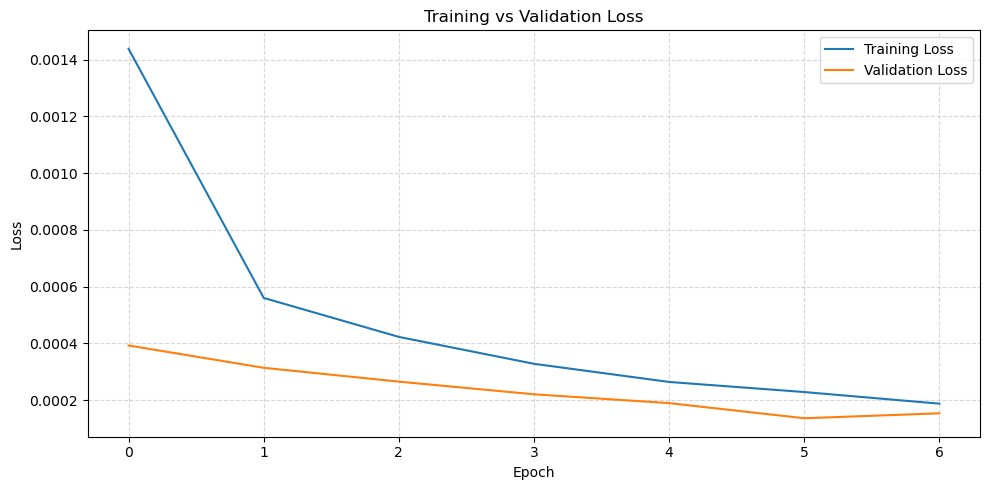

In [61]:
neutral_sentiment.fit_model()

In [62]:
neutral_sentiment_model = neutral_sentiment.forecast_model()

147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


In [63]:
neutral_sentiment.evaluation(neutral_sentiment_model)

mse :  0.0001594880918748221
rmse :  0.012628859484324866
r2 :  0.8713714249899267
mae :  0.009790853153976653


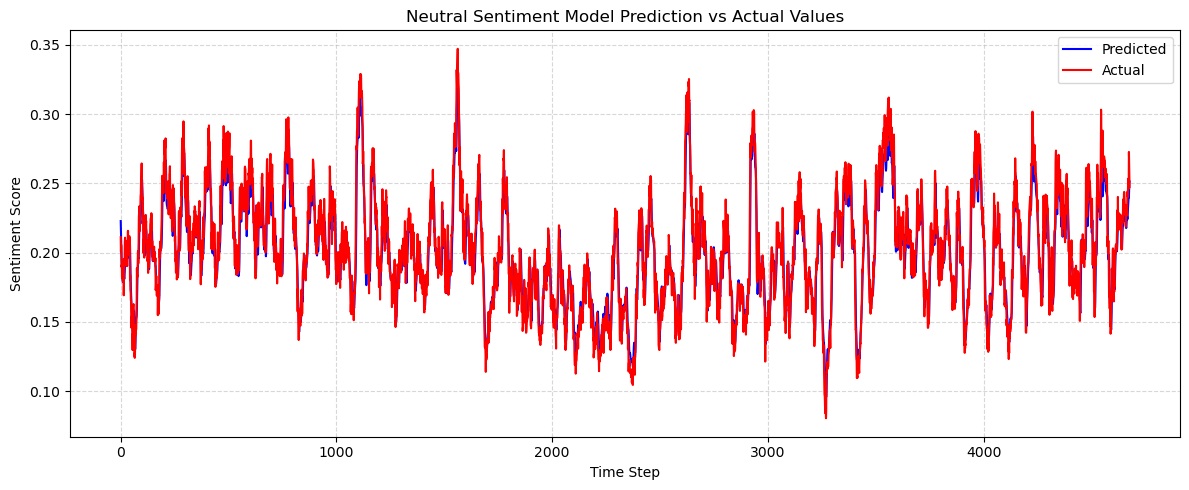

In [64]:
neutral_sentiment.forecast_visual(neutral_sentiment_model,text='Neutral')